In [1]:
import pandas as pd
import scanpy as sc
import scirpy as ir

In [2]:
import sys
sys.path.append('../..')
import tcr_embedding.utils_training as utils
import config.constants_10x as const

from tcr_embedding.utils_preprocessing import group_shuffle_split
from tcr_embedding.evaluation.Imputation import run_imputation_evaluation
from tcr_embedding.evaluation.Clustering import run_clustering_evaluation
from tcr_embedding.evaluation.kNN import run_knn_within_set_evaluation
from tcr_embedding.evaluation.WrapperFunctions import get_model_prediction_function

In [3]:
def load_model(adata, split, model):
    path_model = f'saved_models/journal/Bcells_covid_reac/{model}/bcells_reac_{model}_{split}.pt'
    model = utils.load_model(adata, path_model)
    return model

In [4]:
def load_data(split):
    adata = utils.load_data('Bcells_covid')
    adata.obs['Reactivity'] = (adata.obs['Specificity'] != 'Probe_Negative').astype(str)
    
    random_seed = split
    train_val, test = group_shuffle_split(adata, group_col='clonotype', val_split=0.20, random_seed=random_seed)
    train, val = group_shuffle_split(train_val, group_col='clonotype', val_split=0.25, random_seed=random_seed)

    adata.obs['set'] = 'train'
    adata.obs.loc[val.obs.index, 'set'] = 'val'
    adata.obs.loc[test.obs.index, 'set'] = 'test'
    return adata


In [5]:
metadata = ['Specificity', 'clonotype', 'sample']

model_names = []
splits = []
metrics = []
scores = []

for split in range(0, 4):
    data = load_data(split)

    for model_name in ['moe', 'rna']:
        print(f'split: {split},  model: {model_name}')
        model = load_model(data, split, model_name)
        test_embedding_func = get_model_prediction_function(model)
        for source in ['test']:#, 'val']:
            summary = run_imputation_evaluation(data, test_embedding_func, query_source=source,
                                        label_pred='Reactivity')
            result = summary['knn']['weighted avg']['f1-score']
            
            model_names.append(model_name)
            splits.append(split)
            metrics.append(f'Prediction {source}')
            scores.append(result)
        
        best_nmi = -99
        for resolution in [0.01, 0.1, 1.0]:
            cluster_result = run_clustering_evaluation(data, test_embedding_func, 'train', name_label='Reactivity', 
                                               cluster_params={'resolution': resolution, 'num_neighbors': 5})
            best_nmi = max(cluster_result['NMI'], best_nmi)
        model_names.append(model_name)
        splits.append(split)
        metrics.append('NMI')
        scores.append(best_nmi)
        

results = {
    'model': model_names,
    'split': splits,
    'metrics': metrics,
    'scores': scores,
}
results = pd.DataFrame(results)
results.to_csv('results/performance_bcells_reac.csv')
results

split: 0,  model: moe
split: 0,  model: rna
split: 1,  model: moe
split: 1,  model: rna
split: 2,  model: moe
split: 2,  model: rna
split: 3,  model: moe
split: 3,  model: rna


,model,split,metrics,scores
0,moe,0,Prediction test,0.568829
1,moe,0,NMI,0.004798
2,rna,0,Prediction test,0.580552
3,rna,0,NMI,0.011034
4,moe,1,Prediction test,0.576935
5,moe,1,NMI,0.007924
6,rna,1,Prediction test,0.597831
7,rna,1,NMI,0.013708
8,moe,2,Prediction test,0.582098
9,moe,2,NMI,0.005072


In [6]:
results.groupby(['model', 'metrics'])['scores'].mean()

model  metrics        
moe    NMI                0.006311
       Prediction test    0.578669
rna    NMI                0.011205
       Prediction test    0.593323
Name: scores, dtype: float64

In [7]:
import seaborn as sb

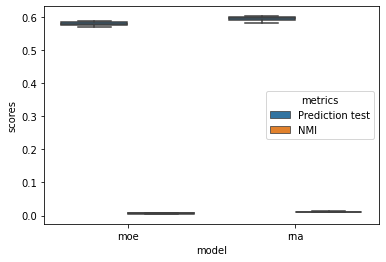

In [8]:
plot = sb.boxplot(data=results[results['metrics'].isin(['Prediction test', 'NMI'])],
                               x='model', y='scores', hue='metrics')

... storing 'Reactivity' as categorical
... storing 'set' as categorical


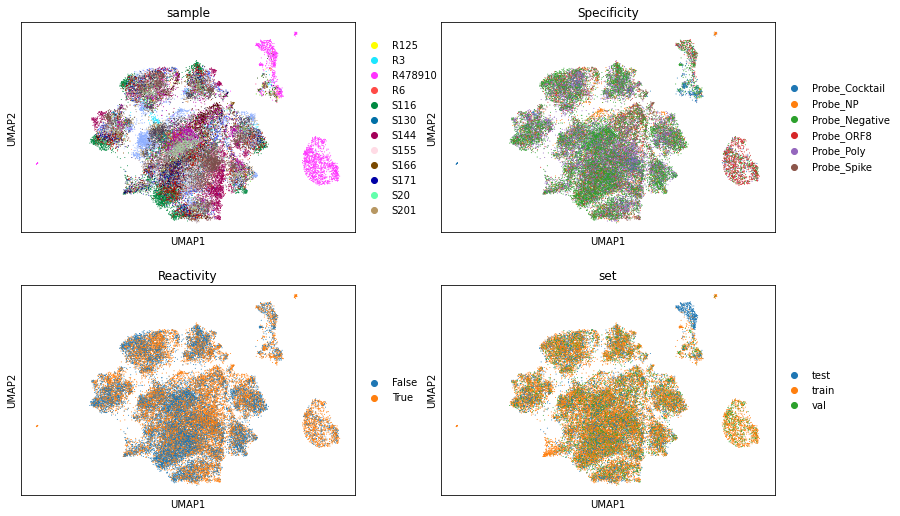

... storing 'Reactivity' as categorical
... storing 'set' as categorical


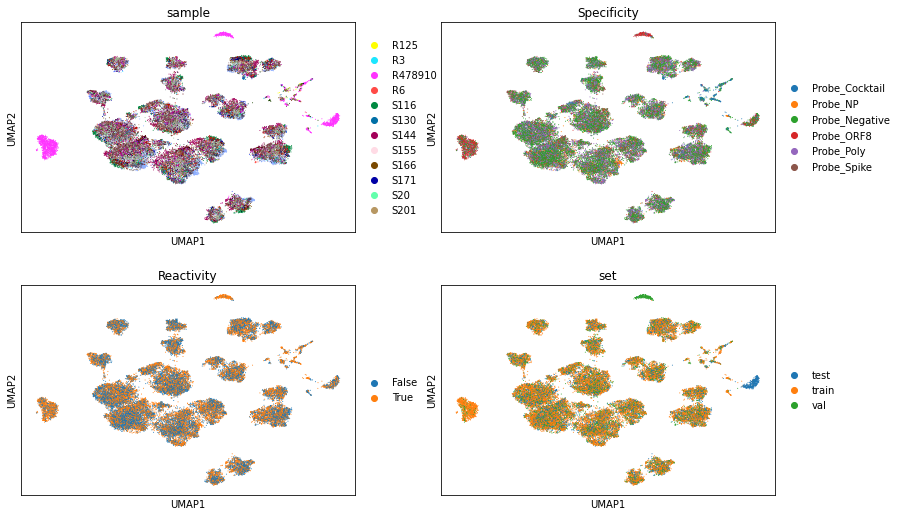

In [9]:
metadata = ['sample', 'Specificity', 'Reactivity', 'set']
data = load_data(0)
data_tmp = data.copy()

for model in ['rna', 'moe']:
    model = load_model(data_tmp, 0, model)
    latent = model.get_latent(data_tmp, metadata=metadata)
    sc.pp.neighbors(latent)
    sc.tl.umap(latent)
    sc.pl.umap(latent, color=metadata, ncols=2)

... storing 'Reactivity' as categorical
... storing 'set' as categorical


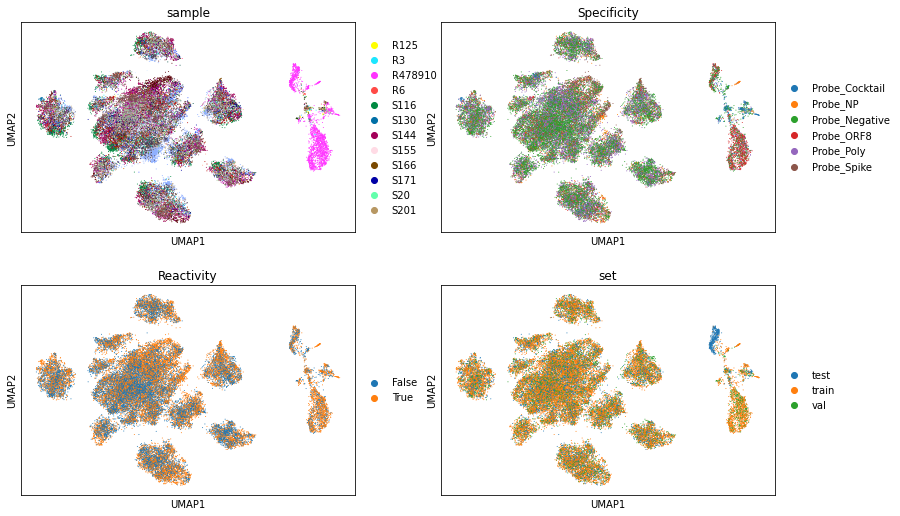

In [10]:
data_tmp = data.copy()
sc.pp.neighbors(data_tmp)
sc.tl.umap(data_tmp)
sc.pl.umap(data_tmp, color=metadata, ncols=2)

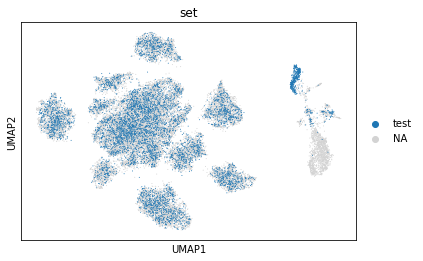

In [11]:
sc.pl.umap(data_tmp, color='set', groups='test', ncols=2)